In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from scipy.signal import welch


In [2]:
from cycler import cycler

def load_plotting_setting():
    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0, 0.95, 5))

    default_cycler = cycler(color=colors)
    
    params = {'figure.figsize': (7, 5),
              'axes.prop_cycle': default_cycler,
              'axes.titlesize': 14,
              'legend.fontsize': 12,
              'axes.labelsize': 14,
              'axes.titlesize': 14,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'xtick.direction': 'in',
              'ytick.direction': 'in',
              'xtick.top': True,
              'ytick.right': True
              }
    plt.rcParams.update(params)

load_plotting_setting()

In [3]:
def get_disp_timestream(file, channels=['d']):
    timestreams = []
    with h5py.File(file, 'r') as f:
        dt = f['data'].attrs['delta_t']

        for channel in channels:
            _ = f['data'][f'channel_{channel}'][:] * f['data'][f'channel_{channel}'].attrs['adc2mv'] / 1000
            timestreams.append(_)
        f.close()

    return dt, timestreams

def get_psd(dt, timestream, nperseg=2**16):
    fs = int(1 / dt)
    ff, pp = welch(timestream, fs, nperseg=nperseg)
    return ff, pp

def get_variance(ff, pp, drive_freq, bandwidth):
    idx = np.logical_and(ff > drive_freq-bandwidth, ff < drive_freq+bandwidth)
    return np.trapz(pp[idx], ff[idx])


In [65]:
# data_dir = r'E:\lorentz_force\sphere_20250708\20250711_5e-8mbar'
data_dir = r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250711_5e-8mbar'

file_0e_noeb = rf'{data_dir}/20250711_0e_noeb_0.hdf5'
file_0e_b    = rf'{data_dir}/20250711_0e_b4_7khz_0.hdf5'
file_0e_eb   = rf'{data_dir}/20250711_0e_b4_7khz_e69khz_0.hdf5'

file_m160e_eb_0_05 = rf'{data_dir}/20250711_minus160e_b4_7khz_e69khz_0_05vpp_0.hdf5'
file_m160e_eb_0_1 = rf'{data_dir}/20250711_minus160e_b4_7khz_e69khz_0_1vpp_0.hdf5'
file_m160e_eb_0_15 = rf'{data_dir}/20250711_minus160e_b4_7khz_e69khz_0_15vpp_0.hdf5'
file_m160e_eb_0_2 = rf'{data_dir}/20250711_minus160e_b4_7khz_e69khz_0_2vpp_0.hdf5'
file_m160e_eb_0_25 = rf'{data_dir}/20250711_minus160e_b4_7khz_e69khz_0_25vpp_0.hdf5'
file_m160e_eb_0_3 = rf'{data_dir}/20250711_minus160e_b4_7khz_e69khz_0_3vpp_0.hdf5'
file_m160e_eb_0_35 = rf'{data_dir}/20250711_minus160e_b4_7khz_e69khz_0_35vpp_0.hdf5'

## Neutral sphere

In [75]:
ff = None
pps_0e = []
for file in [file_0e_noeb, file_0e_b, file_0e_eb]:
    pps = []
    dt, tt = get_disp_timestream(file, ['a', 'b', 'c', 'd'])

    for _t in tt:
        ff, pp = get_psd(dt, _t)
        pps.append(pp)
    pps_0e.append(pps)

pps_0e = np.array(pps_0e)

Text(0, 0.5, 'PSD (V$^2$/Hz)')

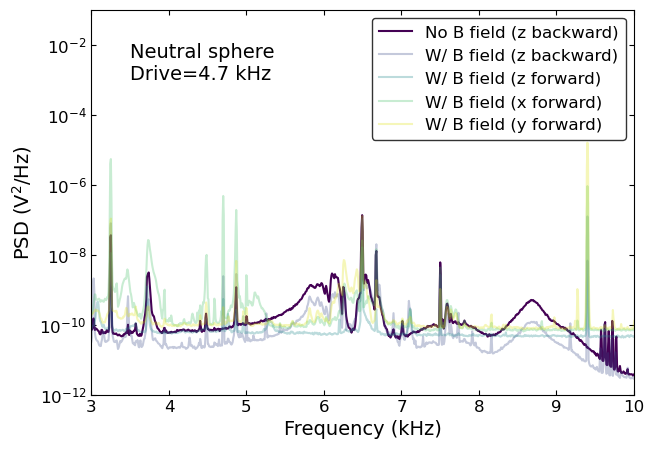

In [100]:
plt.plot(ff/1000, pps_0e[0][3], alpha=1, label='No B field (z backward)')

plt.plot(ff/1000, pps_0e[1][3], alpha=0.3, label='W/ B field (z backward)')
plt.plot(ff/1000, pps_0e[1][2], alpha=0.3, label='W/ B field (z forward)')
plt.plot(ff/1000, pps_0e[1][0], alpha=0.3, label='W/ B field (x forward)')
plt.plot(ff/1000, pps_0e[1][1], alpha=0.3, label='W/ B field (y forward)')

plt.yscale('log')
plt.xlim(3, 10)
plt.ylim(1e-12, 1e-1)

plt.text(3.5, 1e-3, 'Neutral sphere\nDrive=4.7 kHz', fontsize=14)
plt.legend(frameon=True, edgecolor='k')
plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (V$^2$/Hz)')

## Highly (negatively) charged sphere ($\approx 160 e$)

In [135]:
ff = None
pps_160e = []
for file in [file_m160e_eb_0_05, file_m160e_eb_0_1, file_m160e_eb_0_15, file_m160e_eb_0_2, file_m160e_eb_0_25, file_m160e_eb_0_3, file_m160e_eb_0_35]:
    dt, tt = get_disp_timestream(file, ['d'])
    ff, pp = get_psd(dt, tt[0])
    pps_160e.append(pp)

pps_160e = np.array(pps_160e)

(30.0, 100.0)

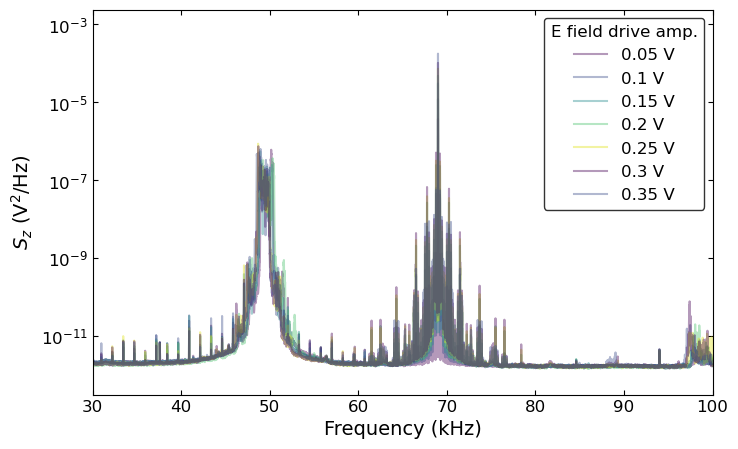

In [134]:
vpp = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i, pp in enumerate(pps_160e):
    ax.plot(ff/1000, pp, alpha=0.4, label=f'{vpp[i]} V')

ax.legend(frameon=True, title='E field drive amp.', title_fontsize=12, edgecolor='k')
ax.set_yscale('log')
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('$S_z$ (V$^2$/Hz)')

ax.set_xlim(30, 100)

(71.7, 75.7)

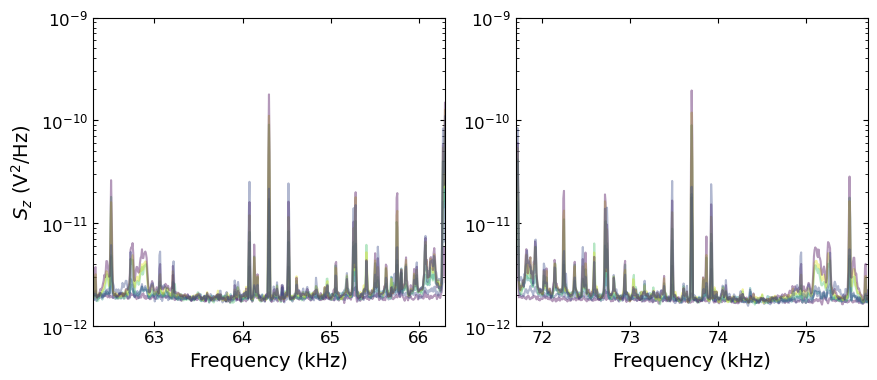

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax in axes:
    for pp in pps_160e[:]:
        ax.plot(ff/1000, pp, alpha=0.4)

    ax.set_yscale('log')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylim(1e-12, 1e-9)

axes[0].set_ylabel('$S_z$ (V$^2$/Hz)')

axes[0].set_xlim(64.3-2, 64.3+2)
axes[1].set_xlim(73.7-2, 73.7+2)

Text(0, 0.5, '$\\langle z^2 \\rangle$ (V$^2$)')

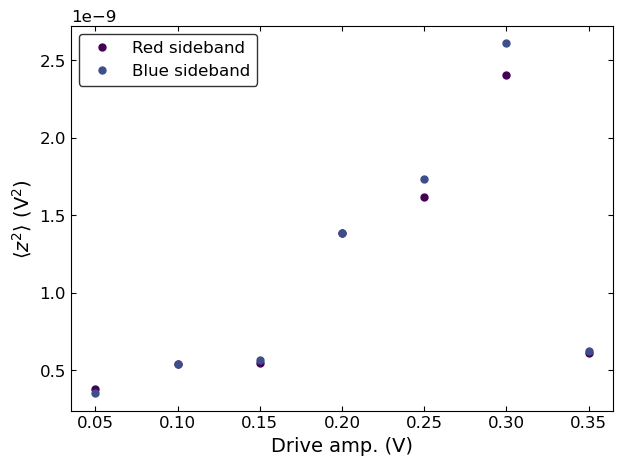

In [149]:
var_64300 = [get_variance(ff, pp, 64300, 100) for pp in pps_160e]
var_73700 = [get_variance(ff, pp, 73700, 100) for pp in pps_160e]

plt.plot(vpp, var_64300, '.', markersize=10, label='Red sideband')
plt.plot(vpp, var_73700, '.', markersize=10, label='Blue sideband')

plt.legend(edgecolor='k')
plt.xlabel('Drive amp. (V)')
plt.ylabel(r'$\langle z^2 \rangle$ (V$^2$)')


## 20250714 data ($\approx 130? 110? e$)

In [19]:
data_dir = r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250714_4e-8mbar'

file_m130e_b5_e0 = rf'{data_dir}/20250714_minus130e_b4_3khz_5vpp_e69khz_0vpp_0.hdf5'
file_m130e_b5_e0_1 = rf'{data_dir}/20250714_minus130e_b4_3khz_5vpp_e69khz_0_1vpp_0.hdf5'
file_m130e_b5_e0_2 = rf'{data_dir}/20250714_minus130e_b4_3khz_5vpp_e69khz_0_2vpp_0.hdf5'
file_m130e_b5_e0_3 = rf'{data_dir}/20250714_minus130e_b4_3khz_5vpp_e69khz_0_3vpp_0.hdf5'
file_m130e_b5_e0_4 = rf'{data_dir}/20250714_minus130e_b4_3khz_5vpp_e69khz_0_4vpp_0.hdf5'
file_m130e_b5_e0_5 = rf'{data_dir}/20250714_minus130e_b4_3khz_5vpp_e69khz_0_5vpp_0.hdf5'

file_m130e_b0_e0_5 = rf'{data_dir}/20250714_minus130e_b4_3khz_0vpp_e69khz_0_5vpp_b_0.hdf5'
file_m130e_b1_e0_5 = rf'{data_dir}/20250714_minus130e_b4_3khz_1vpp_e69khz_0_5vpp_b_0.hdf5'
file_m130e_b2_e0_5 = rf'{data_dir}/20250714_minus130e_b4_3khz_2vpp_e69khz_0_5vpp_b_0.hdf5'
file_m130e_b3_e0_5 = rf'{data_dir}/20250714_minus130e_b4_3khz_3vpp_e69khz_0_5vpp_b_0.hdf5'
file_m130e_b4_e0_5 = rf'{data_dir}/20250714_minus130e_b4_3khz_4vpp_e69khz_0_5vpp_b_0.hdf5'
file_m130e_b5_e0_5 = rf'{data_dir}/20250714_minus130e_b4_3khz_5vpp_e69khz_0_5vpp_b_0.hdf5'

In [ ]:
ff = None
pps_130e = []
for file in [file_m130e_b5_e0, file_m130e_b5_e0_1, file_m130e_b5_e0_2, file_m130e_b5_e0_3, file_m130e_b5_e0_4, file_m130e_b5_e0_5]:
    dt, tt = get_disp_timestream(file, ['d'])
    ff, pp = get_psd(dt, tt[0])
    pps_130e.append(pp)

pps_130e = np.array(pps_130e)

(71.3, 75.3)

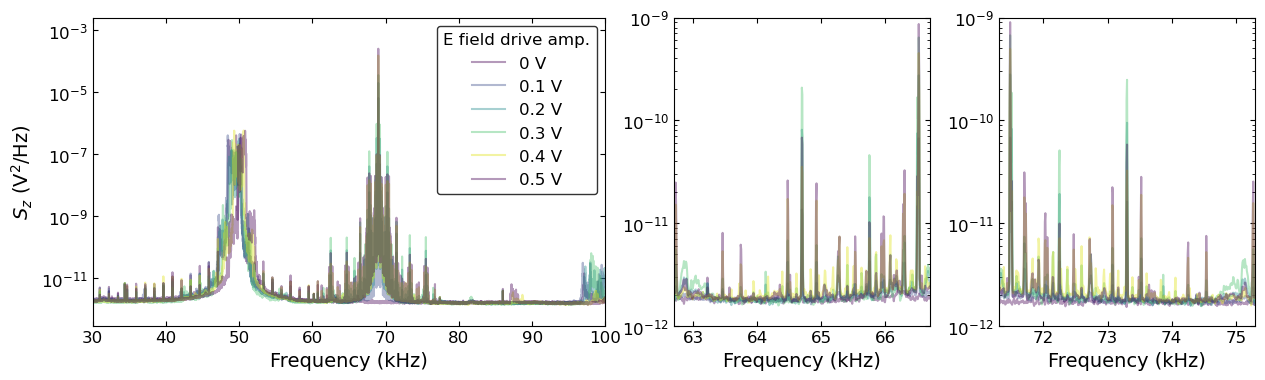

In [34]:
vpp_e = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), width_ratios=[2, 1, 1])

ax = axes[0]
for i, pp in enumerate(pps_130e):
    ax.plot(ff/1000, pp, alpha=0.4, label=f'{vpp_e[i]} V')

ax.legend(frameon=True, title='E field drive amp.', title_fontsize=12, edgecolor='k')
ax.set_yscale('log')
ax.set_xlabel('Frequency (kHz)')
ax.set_xlim(30, 100)

for ax in axes[1:]:
    for pp in pps_130e[:]:
        ax.plot(ff/1000, pp, alpha=0.4)

    ax.set_yscale('log')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylim(1e-12, 1e-9)

axes[0].set_ylabel('$S_z$ (V$^2$/Hz)')

axes[1].set_xlim(64.7-2, 64.7+2)
axes[2].set_xlim(73.3-2, 73.3+2)

In [20]:
pps_130e_b = []
for file in [file_m130e_b0_e0_5, file_m130e_b1_e0_5, file_m130e_b2_e0_5, file_m130e_b3_e0_5, file_m130e_b4_e0_5, file_m130e_b5_e0_5]:
    dt, tt = get_disp_timestream(file, ['d'])
    ff, pp = get_psd(dt, tt[0])
    pps_130e_b.append(pp)

pps_130e_b = np.array(pps_130e_b)

(71.3, 75.3)

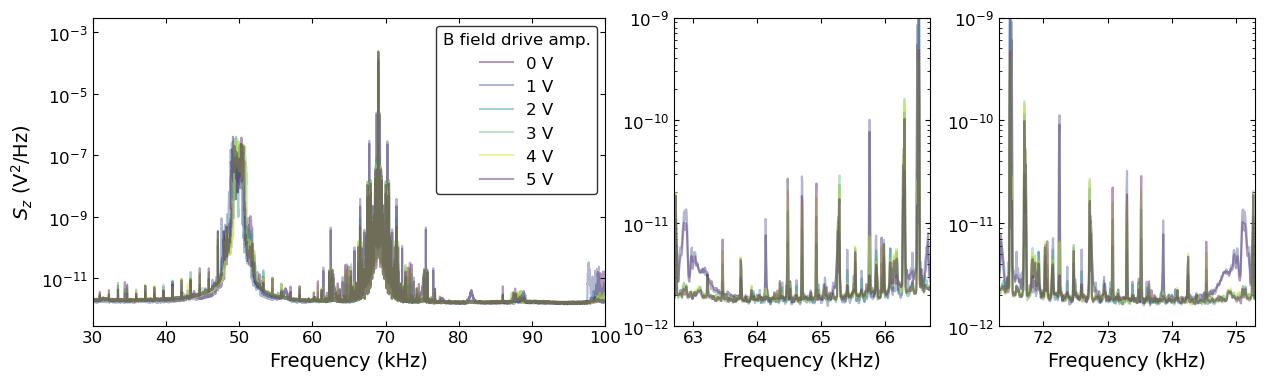

In [62]:
vpp_b = [0, 1, 2, 3, 4, 5]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), width_ratios=[2, 1, 1])

ax = axes[0]
for i, pp in enumerate(pps_130e_b):
    ax.plot(ff/1000, pp, alpha=0.4, label=f'{vpp_b[i]} V')

ax.legend(frameon=True, title='B field drive amp.', title_fontsize=12, edgecolor='k')
ax.set_yscale('log')
ax.set_xlabel('Frequency (kHz)')
ax.set_xlim(30, 100)

for ax in axes[1:]:
    for pp in pps_130e_b[:]:
        ax.plot(ff/1000, pp, alpha=0.4)

    ax.set_yscale('log')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylim(1e-12, 1e-9)

axes[0].set_ylabel('$S_z$ (V$^2$/Hz)')

axes[1].set_xlim(64.7-2, 64.7+2)
axes[2].set_xlim(73.3-2, 73.3+2)
# axes[1].set_xlim(64.7-0.225, 64.7+0.225)
# axes[2].set_xlim(73.3-0.225, 73.3+0.225)

Text(0.5, 0, 'B field drive amplitude (V)')

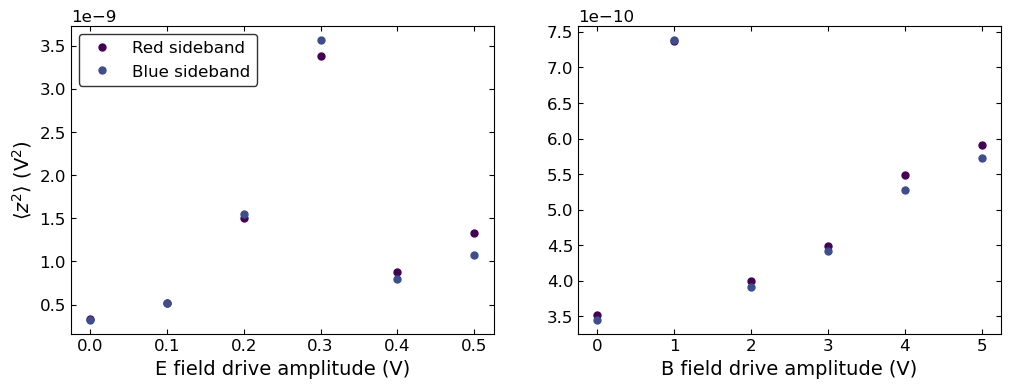

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

var_64700 = [get_variance(ff, pp, 64700, 100) for pp in pps_130e]
var_73300 = [get_variance(ff, pp, 73300, 100) for pp in pps_130e]

axes[0].plot(vpp_e, var_64700, '.', markersize=10, label='Red sideband')
axes[0].plot(vpp_e, var_73300, '.', markersize=10, label='Blue sideband')

axes[0].legend(edgecolor='k')
axes[0].set_xlabel('E field drive amplitude (V)')
axes[0].set_ylabel(r'$\langle z^2 \rangle$ (V$^2$)')

var_64700_b = [get_variance(ff, pp, 64700, 100) for pp in pps_130e_b]
var_73300_b = [get_variance(ff, pp, 73300, 100) for pp in pps_130e_b]

axes[1].plot(vpp_b, var_64700_b, '.', markersize=10, label='Red sideband')
axes[1].plot(vpp_b, var_73300_b, '.', markersize=10, label='Blue sideband')

# axes[1].legend(edgecolor='k')
axes[1].set_xlabel('B field drive amplitude (V)')

In [3]:
m = 5e-18 # kg  
n_charge = 350
q = n_charge * 1.6e-19 # C
vpp = 350  # V

E0 = vpp / 2 * 100  # V/m
B0 = 100e-4 # Tesla

omega0_x = 220000 * 2 * np.pi
omega0_z = 50000 * 2 * np.pi
omegaE = 276000 * 2 * np.pi

# omegaB = 117000 * 2 * np.pi
# omega1 = omegaE + omegaB
# omega2 = omegaE - omegaB

v0 = (q * E0 * omegaE / m) / np.abs((omega0_x**2 - omegaE**2))
F0 = q * v0 * B0
# A = (1 / (2 * m)) * q**2 * E0 * B0 * omegaE / np.sqrt((omega0**2 - omegaE**2)**2)

In [4]:
print(F0, 'N')
print(v0)
# print( (np.pi * F0**2 / (2 * m**2)) / ((omega0_z**2 - omega2**2)**2) )

1.7358156857861225e-19 N
0.3099670867475219
